# Ensemble Learning and Random Forests

 If you aggregate the
 predictions of a group of predictors (such as classifiers or regressors), you will often get
 better predictions than with the best individual predictor. A group of predictors is called
 an ensemble; thus, this technique is called ensemble learning, and an ensemble learning
 algorithm is called an ensemble method.

 As an example of an ensemble method, you can train a group of decision tree
 classifiers, each on a different random subset of the training set. You can then obtain
 the predictions of all the individual trees, and the class that gets the most votes is the
 ensemble’s prediction (see the last exercise in Chapter 6). Such an ensemble of decision
 trees is called a random forest, and despite its simplicity, this is one of the most
 powerful machine learning algorithms available today.

you will often use ensemble methods near the end of a
 project, once you have already built a few good predictors, to combine them into an
 even better predictor. In fact, the winning solutions in machine learning competitions
 often involve several ensemble methods—most famously in the Netflix Prize
 competition.

 In this chapter we will examine the most popular ensemble methods, including voting
 classifiers, bagging and pasting ensembles, random forests, and boosting, and stacking
 ensembles.

## Voting Classifiers

Suppose you have trained a few classifiers, each one achieving about 80% accuracy.
 You may have a logistic regression classifier, an SVM classifier, a random forest
 classifier, a k-nearest neighbors classifier, and perhaps a few more.

 A very simple way to create an even better classifier is to aggregate the predictions of
 each classifier: the class that gets the most votes is the ensemble’s prediction. This
 majority-vote classifier is called a hard voting classifier 

#### TIP:

Ensembles class work best when the predictors are as independent from one another as possible. One
 way to get diverse classifiers is to train them using very different algorithms. This increases the chance
 that they will make very different types of errors, improving the ensemble’s accuracy.


Scikit-Learn provides a VotingClassifier class that’s quite easy to use: just give
 it a list of name/predictor pairs, and use it like a normal classifier. Let’s try it on the
 moons dataset (introduced in Chapter 5). We will load and split the moons dataset into
 a training set and a test set, then we’ll create and train a voting classifier composed of
 three diverse classifiers:

In [1]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

x, y = make_moons(n_samples=1000, random_state=50)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=50)), 
        ("rf", RandomForestClassifier(random_state=50)), 
        ('svc', SVC(random_state=50))
    ])
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=50)),
                             ('rf', RandomForestClassifier(random_state=50)),
                             ('svc', SVC(random_state=50))])

When you fit a VotingClassifier, it clones every estimator and fits the clones.
 The original estimators are available via the estimators attribute, while the fitted
 clones are available via the estimators_ attribute. If you prefer a dict rather than a
 list, you can use named_estimators or named_estimators_ instead. To begin,
 let’s look at each fitted classifier’s accuracy on the test set:

In [2]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, '=', clf.score(x_test, y_test))

lr = 0.8833333333333333
rf = 1.0
svc = 1.0


When you call the voting classifier’s predict() method, it performs hard voting.
 For example, the voting classifier predicts class 1 for the first instance of the test set,
 because two out of three classifiers predict that class:

In [3]:
voting_clf.predict(x_test[:1])
[clf.predict(x_test[:1]) for clf in voting_clf.estimators_]

[array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64)]

 Now let’s look at the performance of the voting classifier on the test set:

In [4]:
voting_clf.score(x_test, y_test)

1.0

 There you have it! The voting classifier outperforms all the individual classifiers.
 If all classifiers are able to estimate class probabilities (i.e., if they all have a
 predict_proba() method), then you can tell Scikit-Learn to predict the class with
 the highest class probability, averaged over all the individual classifiers. This is called
 soft voting.

It often achieves higher performance than hard voting because it gives more
 weight to highly confident votes. All you need to do is set the voting classifier’s
 voting hyperparameter to "soft", and ensure that all classifiers can estimate class
 probabilities. This is not the case for the SVC class by default, so you need to set its
 probability hyperparameter to True (this will make the SVC class use cross
validation to estimate class probabilities, slowing down training, and it will add a
 predict_proba() method). Let’s try that:

In [5]:
voting_clf.voting = 'soft'
voting_clf.named_estimators['svc'].probability = True
voting_clf.fit(x_train, y_train)
voting_clf.score(x_test, y_test)

1.0

## Bagging and Pasting

 Another approach is to use the same training algorithm for every
 predictor but train them on different random subsets of the training set. When sampling
 is performed with replacement,  this method is called bagging  (short for bootstrap
 aggregating ). When sampling is performed without replacement, it is called pasting.

bagging allows some data points to be used multiple times in different models while pasting ensures each data point is used only once per subset.

 Once all predictors are trained, the ensemble can make a prediction for a new instance
 by simply aggregating the predictions of all predictors. The aggregation function is
 typically the statistical mode for classification

### Bagging and Pasting in Scikit-Learn

 Scikit-Learn offers a simple API for both bagging and pasting:
  BaggingClassifier class (or BaggingRegressor for regression). The
 following code trains an ensemble of 500 decision tree classifiers:  each is trained on
 100 training instances randomly sampled from the training set with replacement (this is
 an example of bagging, but if you want to use pasting instead, just set
 6
 bootstrap=False). The n_jobs parameter tells Scikit-Learn the number of CPU
 cores to use for training and predictions, and –1 tells Scikit-Learn to use all available
 cores:


In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bg_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, 
                                  max_samples=100, n_jobs=-1, random_state=50)
bg_clf.fit(x_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=50)

#### NOTE:

A BaggingClassifier automatically performs soft voting instead of hard voting if the base
 classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the
 case with decision tree classifiers.

Introducing Bagging with several trees/ samples regularize morre than using a single model. 

### Out-of-Bag Evaluation

 With bagging, some training instances may be sampled several times for any given
 predictor, while others may not be sampled at all. By default a
7
 BaggingClassifier samples m training instances with replacement
 (bootstrap=True), where m is the size of the training set. With this process, it can
 be shown mathematically that only about 63% of the training instances are sampled on
 average for each predictor.  The remaining 37% of the training instances that are not
 sampled are called out-of-bag (OOB) instances. Note that they are not the same 37%
 for all predictors.

. Once you have a
 prediction for each instance, you can compute the ensemble’s prediction accuracy (or
 any other metric).
 In Scikit-Learn, you can set oob_score=True when creating a
 BaggingClassifier to request an automatic OOB evaluation after training. The
 following code demonstrates this. The resulting evaluation score is available in the
 oob_score_ attribute:

In [7]:
bag_classifier = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, 
                                   oob_score=True, n_jobs=-1, random_state=50)
bag_classifier.fit(x_train, y_train)
bag_classifier.oob_score_

0.9942857142857143

 According to this OOB evaluation, this BaggingClassifier is likely to achieve
 about 99.4% accuracy on the test set. Let’s verify this:

In [8]:
from sklearn.metrics import accuracy_score
y_pred = bag_classifier.predict(x_test)
accuracy_score(y_test, y_pred)

1.0

Wow!  We get 100% accuracy on the test. The OOB evaluation was a bit too pessimistic, just
 over 0.6% too low.

 The OOB decision function for each training instance is also available through the
 oob_decision_function_ attribute. Since the base estimator has a
 predict_proba() method, the decision function returns the class probabilities for
 each training instance. For example, the OOB evaluation estimates that the first training
 instance has a 67.6% probability of belonging to the positive class and a 32.4%
 probability of belonging to the negative class:


In [9]:
bag_classifier.oob_decision_function_[:5]

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.94011976, 0.05988024],
       [0.        , 1.        ]])

### Random Patches and Random Subspaces

 The BaggingClassifier class supports sampling the features as well. Sampling is
 controlled by two hyperparameters: max_features and bootstrap_features.  They work the same way as max_samples and bootstrap, but for feature
 sampling instead of instance sampling. Thus, each predictor will be trained on a
 random subset of the input features.

 This technique is particularly useful when you are dealing with high-dimensional
 inputs (such as images), as it can considerably speed up training. Sampling both
 training instances and features is called the random patches method.  Keeping all
 training instances (by setting bootstrap=False and max_samples=1.0) but
 sampling features (by setting bootstrap_features to True and/or
 max_features to a value smaller than 1.0) is called the random subspaces
 method.

## Random Forests

 As we have discussed, a random forest  is an ensemble of decision trees, generally
 trained via the bagging method (or sometimes pasting), typically with max_samples
 set to the size of the training set. Instead of building a BaggingClassifier and
 passing it a DecisionTreeClassifier, you can use the
 11
 RandomForestClassifier class, which is more convenient and optimized for
 decision trees  (similarly, there is a RandomForestRegressor class for
 regression tasks). The following code trains a random forest classifier with 500 trees,
 each limited to maximum 16 leaf nodes, using all available CPU cores:

In [10]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, 
                                 n_jobs=-1, random_state=50)
rnd_clf.fit(x_train, y_train)
y_pred_rf = rnd_clf.predict(x_test)

With a few exceptions, a RandomForestClassifier has all the hyperparameters
 of a DecisionTreeClassifier (to control how trees are grown), plus all the
 hyperparameters of a BaggingClassifier to control the ensemble itself.

 The random forest algorithm introduces extra randomness when growing trees; instead
 of searching for the very best feature when splitting a node (see Chapter 6), it searches
 for the best feature among a random subset of features. By default, it samples 
√
 n
 features (where n is the total number of features). The algorithm results in greater tree
 diversity, which (again) trades a higher bias for a lower variance, generally yielding an
 overall better model. So, the following BaggingClassifier is equivalent to the
 previous RandomForestClassifier:

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16), 
                           n_estimators=500, n_jobs=-1, random_state=50)

### Extra-Trees

When you are growing a tree in a random forest, at each node only a random subset of
 the features is considered for splitting (as discussed earlier). It is possible to make trees
 even more random by also using random thresholds for each feature rather than
 searching for the best possible thresholds (like regular decision trees do). For this,
 simply set splitter="random" when creating a DecisionTreeClassifier.

 A forest of such extremely random trees is called an extremely randomized trees  (or
 extra-trees for short) ensemble. Once again, this technique trades more bias for a lower
 variance. It also makes extra-trees classifiers much faster to train than regular random
 forests, because finding the best possible threshold for each feature at every node is one
 of the most time-consuming tasks of growing a tree.

 You can create an extra-trees classifier using Scikit-Learn’s
 ExtraTreesClassifier class. Its API is identical to the
 RandomForestClassifier class, except bootstrap defaults to False.
 Similarly, the ExtraTreesRegressor class has the same API as the
 RandomForestRegressor class, except bootstrap defaults to False.

#### TIP:
 It is hard to tell in advance whether a RandomForestClassifier will perform better or worse
 than an ExtraTreesClassifier. Generally, the only way to know is to try both and compare them
 using cross-validation.


### Feature Importance

Yet another great quality of random forests is that they make it easy to measure the
 relative importance of each feature. Scikit-Learn measures a feature’s importance by
 looking at how much the tree nodes that use that feature reduce impurity on average,
 across all trees in the forest. More precisely, it is a weighted average, where each
 node’s weight is equal to the number of training samples that are associated with it 

 Scikit-Learn computes this score automatically for each feature after training, then it
 scales the results so that the sum of all importances is equal to 1. You can access the
 result using the feature_importances_ variable. For example, the following
 code trains a RandomForestClassifier on the iris dataset (introduced in
 Chapter 4) and outputs each feature’s importance. It seems that the most important
 features are the petal length (42%) and width (46%), while sepal length and width are
 rather unimportant in comparison (9% and 2%, respectively):

In [12]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=50)
rnd_clf.fit(iris.data, iris.target)

for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.09 sepal length (cm)
0.02 sepal width (cm)
0.42 petal length (cm)
0.46 petal width (cm)


 Random forests are very handy to get a quick understanding of what features actually
 matter, in particular if you need to perform feature selection.

## BOOSTING

 Refers to any ensemble method that can
 combine several weak learners into a strong learner. The general idea of most boosting
 methods is to train predictors sequentially, each trying to correct its predecessor. There
 are many boosting methods available, but by far the most popular are AdaBoost 
(short for adaptive boosting) and gradient boosting. Let’s start with AdaBoost.

### AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention to
 the training instances that the predecessor underfit. This results in new predictors
 focusing more and more on the hard cases. This is the technique used by AdaBoost.

 For example, when training an AdaBoost classifier, the algorithm first trains a base
 classifier (such as a decision tree) and uses it to make predictions on the training set.
 The algorithm then increases the relative weight of misclassified training instances.
 Then it trains a second classifier, using the updated weights, and again makes
 predictions on the training set, updates the instance weights, and so on.

 As you can see, this sequential learning technique has some similarities
 with gradient descent, except that instead of tweaking a single predictor’s parameters to
 minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making
 it better.
 Once all predictors are trained, the ensemble makes predictions very much like bagging
 or pasting, except that predictors have different weights depending on their overall
 accuracy on the weighted training set.


#### WARNING:

There is one important drawback to this sequential learning technique: training cannot be parallelized
 since each predictor can only be trained after the previous predictor has been trained and evaluated. As
 a result, it does not scale as well as bagging or pasting.

Consider The mathematical Explanations from the Book....

 Scikit-Learn uses a multiclass version of AdaBoost called SAMME  (which stands for
 Stagewise Additive Modeling using a Multiclass Exponential loss function). When there
 are just two classes, SAMME is equivalent to AdaBoost. If the predictors can estimate
 class probabilities (i.e., if they have a predict_proba() method), Scikit-Learn can
 use a variant of SAMME called SAMME.R (the R stands for “Real”), which relies on
 class probabilities rather than predictions and generally performs better.

 The following code trains an AdaBoost classifier based on 30 decision stumps using
 Scikit-Learn’s AdaBoostClassifier class (as you might expect, there is also an
 AdaBoostRegressor class). A decision stump is a decision tree with
 max_depth=1—in other words, a tree composed of a single decision node plus two
 leaf nodes. This is the default base estimator for the AdaBoostClassifier class:

In [13]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(x_train, y_train)

d:\CONTENTS\APPLICATIONS\New Folder\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

#### TIP:

If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator.

### Gradient Boosting

Just like AdaBoost,
 gradient boosting works by sequentially adding predictors to an ensemble, each one
 correcting its predecessor. However, instead of tweaking the instance weights at every
 iteration like AdaBoost does, this method tries to fit the new predictor to the residual
 errors made by the previous predictor.

 Let’s go through a simple regression example, using decision trees as the base
 predictors; this is called gradient tree boosting, or gradient boosted regression trees
 (GBRT). First, let’s generate a noisy quadratic dataset and fit a
 DecisionTreeRegressor to it:

In [14]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(50)
x = np.random.rand(100, 1) - 0.5
y = 3 * x[:, 0] ** 2 + 0.05 * np.random.randn(100) # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(x, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Next, we’ll train a second DecisionTreeRegressor on the residual errors made
 by the first predictor:

In [15]:
y2 = y - tree_reg1.predict(x)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=50)
tree_reg2.fit(x, y2)

DecisionTreeRegressor(max_depth=2, random_state=50)

 And then we’ll train a third regressor on the residual errors made by the second
 predictor:

In [16]:
y3 = y - tree_reg2.predict(x)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=45)
tree_reg3.fit(x, y3)

DecisionTreeRegressor(max_depth=2, random_state=45)

Now we have an ensemble containing three trees. It can make predictions on a new
 instance simply by adding up the predictions of all the trees:

In [17]:
x_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(x_new) for tree in (tree_reg1, tree_reg2, tree_reg3))


array([1.11040618, 0.12040689, 1.28162215])

 You can use Scikit-Learn’s GradientBoostingRegressor class to train GBRT
 ensembles more easily (there’s also a GradientBoostingClassifier class for
 classification). Much like the RandomForestRegressor class, it has
 hyperparameters to control the growth of decision trees (e.g., max_depth,
 min_samples_leaf), as well as hyperparameters to control the ensemble training,
 such as the number of trees (n_estimators). The following code creates the same
 ensemble as the previous one:

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=50)
gbrt.fit(x, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=50)

 To find the optimal number of trees, you could perform cross-validation using
 GridSearchCV or RandomizedSearchCV, as usual, but there’s a simpler way: if
 you set the n_iter_no_change hyperparameter to an integer value, say 10, then the
 GradientBoostingRegressor will automatically stop adding more trees during
 training if it sees that the last 10 trees didn’t help. This is simply early stopping
 (introduced in Chapter 4), but with a little bit of patience: it tolerates having no
 progress for a few iterations before it stops. Let’s train the ensemble using early
 stopping:

In [19]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500, 
    n_iter_no_change=10, random_state=50)
gbrt_best.fit(x, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=50)

 If you set n_iter_no_change too low, training may stop too early and the model
 will underfit. But if you set it too high, it will overfit instead. We also set a fairly small
 learning rate and a high number of estimators, but the actual number of estimators in
 the trained ensemble is much lower, thanks to early stopping:

In [20]:
gbrt_best.n_estimators_

106

 When n_iter_no_change is set, the fit() method automatically splits the
 training set into a smaller training set and a validation set: this allows it to evaluate the
 model’s performance each time it adds a new tree. The size of the validation set is
 controlled by the validation_fraction hyperparameter, which is 10% by
 default. The tol hyperparameter determines the maximum performance improvement
 that still counts as negligible. It defaults to 0.0001.
The GradientBoostingRegressor class also supports a subsample
 hyperparameter, which specifies the fraction of training instances to be used for
 training each tree. For example, if subsample=0.25, then each tree is trained on
 25% of the training instances, selected randomly. As you can probably guess by now,
 this technique trades a higher bias for a lower variance. It also speeds up training
 considerably. This is called stochastic gradient boosting.

### Histogram-Based Gradient Boosting

 Scikit-Learn also provides another GBRT implementation, optimized for large datasets:
 histogram-based gradient boosting (HGB). It works by binning the input features,
 replacing them with integers. The number of bins is controlled by the max_bins
 hyperparameter, which defaults to 255 and cannot be set any higher than this. Binning
 can greatly reduce the number of possible thresholds that the training algorithm needs
 to evaluate. Moreover, working with integers makes it possible to use faster and more
 memory-efficient data structures. And the way the bins are built removes the need for
 sorting the features when training each tree.

 As a result, this implementation has a computational complexity of O(b×m) instead of
 O(n×m×log(m)), where b is the number of bins, m is the number of training instances,
 and n is the number of features. In practice, this means that HGB can train hundreds of
 times faster than regular GBRT on large datasets. However, binning causes a precision
 loss, which acts as a regularizer: depending on the dataset, this may help reduce
 overfitting, or it may cause underfitting.

 Scikit-Learn provides two classes for HGB: HistGradientBoostingRegressor
 and HistGradientBoostingClassifier. They’re similar to
 GradientBoostingRegressor and GradientBoostingClassifier, with
 a few notable differences:
 - Early Stopping is automatically activated if the number of instances is greater than 10,000. You can turn early stopping always on or always off by setting the early_stopping hyperparameter to True of False.
 - Subsampling is not supported.
 - n_estimators is renamed to max_iter.
 - The only decision tree hyperparameter that can be tweaked are max_leaf_nodes, min_samples_leaf, and max_depth.

 The HGB classes also have two nice features: they support both categorical features
 and missing values. This simplifies preprocessing quite a bit. However, the categorical
features must be represented as integers ranging from 0 to a number lower than
 max_bins. You can use an OrdinalEncoder for this. For example, here’s how to
 build and train a complete pipeline for the California housing dataset introduced in
 Chapter 2:

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

hgb_reg = make_pipeline(
    make_column_transformer((OrdinHistGradialEncoder(), 
                             ['ocean_proximity']), 
                            remainder='passthrough'), 
    HistGradientBoostingRegressor(categorical_features=[0], 
                                  random_state=50))
hgb_reg.fit(housing, housing_labels)

NameError: name 'OrdinHistGradialEncoder' is not defined

#### TIP:
 Several other optimized implementations of gradient boosting are available in the Python ML
 ecosystem: in particular, XGBoost, CatBoost, and LightGBM. These libraries have been around for
 several years. They are all specialized for gradient boosting, their APIs are very similar to Scikit
Learn’s, and they provide many additional features, including GPU acceleration; you should definitely
 check them out! Moreover, the TensorFlow Random Forests library provides optimized
 implementations of a variety of random forest algorithms, including plain random forests, extra-trees,
 GBRT, and several more.

## Staking

 The last ensemble method we will discuss in this chapter is called stacking (short for
 stacked generalization).  It is based on a simple idea: instead of using trivial functions
 (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why
 don’t we train a model to perform this aggregation? 

 To train the blender, you first need to build the blending training set. You can use
 cross_val_predict() on every predictor in the ensemble to get out-of-sample
 predictions for each instance in the original training set (, and use these can
 be used as the input features to train the blender; and the targets can simply be copied
 from the original training set. Note that regardless of the number of features in the
 original training set , the blending training set will contain one
 input feature per predictor. Once the blender is trained, the base
 predictors are retrained one last time on the full original training set.


 It is actually possible to train several different blenders this way (e.g., one using linear
 regression, another using random forest regression) to get a whole layer of blenders,
 and then add another blender on top of that to produce the final prediction. You may be able to squeeze out a few more drops of performance by
 doing this, but it will cost you in both training time and system complexity.


 Scikit-Learn provides two classes for stacking ensembles: StackingClassifier
 and StackingRegressor. For example, we can replace the
 VotingClassifier we used at the beginning of this chapter on the moons dataset
 with a StackingClassifier:

In [ ]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=50)), 
        ('rf', RandomForestClassifier(random_state=50)), 
        ('svc', SVC(probability=True, random_state=50))
    ], 
    final_estimator=RandomForestClassifier(random_state=42),
    cv=5 # Number of cross-validation folds
)
stacking_clf.fit(x_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=50)),
                               ('rf', RandomForestClassifier(random_state=50)),
                               ('svc', SVC(probability=True, random_state=50))],
                   final_estimator=RandomForestClassifier(random_state=42))

 For each predictor, the stacking classifier will call predict_proba() if available; if
 not it will fall back to decision_function() or, as a last resort, call
 predict(). If you don’t provide a final estimator, StackingClassifier will
 use LogisticRegression and StackingRegressor will use RidgeCV.


 In conclusion, ensemble methods are versatile, powerful, and fairly simple to use.
 Random forests, AdaBoost, and GBRT are among the first models you should test for
 most machine learning tasks, and they particularly shine with heterogeneous tabular
 data. Moreover, as they require very little preprocessing, they’re great for getting a
 prototype up and running quickly. Lastly, ensemble methods like voting classifiers and
 stacking classifiers can help push your system’s performance to its limits.

## EXERCISE:
Load the MNIST dataset (introduced in Chapter 3), and split it into a training set, a
 validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for
 validation, and 10,000 for testing). Then train various classifiers, such as a random
 forest classifier, an extra-trees classifier, and an SVM classifier. Next, try to
 combine them into an ensemble that outperforms each individual classifier on the
 validation set, using soft or hard voting. Once you have found one, try it on the
 test set. How much better does it perform compared to the individual classifiers?


In [49]:
#Loading MNIST Dataset.
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [50]:
x, y = mnist.data, mnist.target

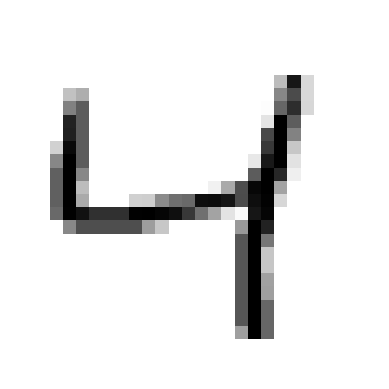

In [86]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
some_digit = x[2]
plot_digit(some_digit)
plt.show()

In [52]:
# Splitting the dataset
from sklearn.model_selection import train_test_split
x_train, x_test, x_valid, y_train, y_test, y_valid = x[:50000], x[50000:60000], x[60000:], y[:50000], y[50000:60000], y[60000:]

#### RandomForestClassifier

In [87]:
# From Support Vector Machine
from sklearn.ensemble import RandomForestClassifier
y_train_3 = (y_train == 3)
rndf_clf = RandomForestClassifier(n_estimators=10, max_leaf_nodes=10, 
                                 n_jobs=-1, random_state=50)
rndf_clf.fit(x_train, y_train)

RandomForestClassifier(max_leaf_nodes=10, n_estimators=10, n_jobs=-1,
                       random_state=50)

In [88]:
# Performance Measures
rndf_clf.predict([x[55_000]])

array(['1'], dtype=object)

In [89]:
from sklearn.model_selection import cross_val_score
cross_val_score(rndf_clf, x_train, y_train_3, cv=3, 
scoring="accuracy")

array([1., 1., 1.])

##### SVM Classifier

In [92]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=50)
svm_clf.fit(x_train, y_train)

SVC(random_state=50)

In [93]:
svm_clf.predict([x[55000]])

array(['1'], dtype=object)

#### LogisticRegression

In [112]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=50)
log_reg.fit(x_train, y_train)

d:\CONTENTS\APPLICATIONS\New Folder\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=50)

In [113]:
log_reg.predict([x_test[5]])

array(['4'], dtype=object)

## Combining them in voting

In [123]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

voting_classifier = VotingClassifier(estimators=[svm_clf, log_reg, rndf_clf])
voting_classifier.fit(x_train, y_train)

TypeError: 'SVC' object is not iterable

In [125]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
        ]
    )
voting_clf.fit(x_train, y_train)

d:\CONTENTS\APPLICATIONS\New Folder\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [128]:
for name, clf in voting_clf.named_estimators_.items():   
    print(name, "=", clf.score(x_test, y_test))

lr = 0.0
rf = 0.0
svc = 0.0
